<div style="max-width:66ch;">

# Lecture notes - Data augmentation

This is the lecture note for **data augmentation**. 

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to data augmentation. I encourage you to read further about data augmentation. </p>

Read more:

- [ImageDataGenerator - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?version=nightly)
- [Data augmentation - wikipedia](https://en.wikipedia.org/wiki/Data_augmentation)
- [Data augmentation cheat sheet - S. Amidi](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks)

</div>


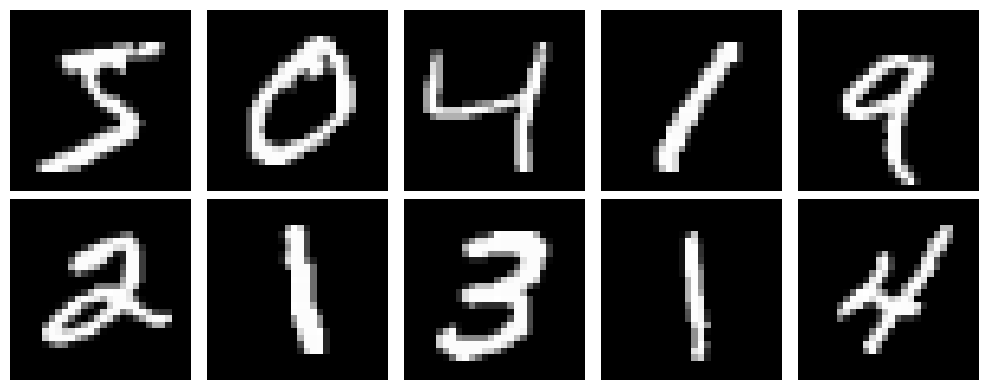

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data
import numpy as np

(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(X_train)


In [14]:

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
print(f"{X_train.min()=}, {X_train.max()=}")

X_train.min()=0.0, X_train.max()=1.0


## Train|val|test split

In [15]:
from sklearn.model_selection import train_test_split


# we already have X_train: 60000 samples 
# X_train_val: 50000 samples -> training part for validation and hyperparameter tuning
# X_val: 10000 samples -> validation used for hyperparameter tuning and validation loss curves
# train on train_val and validate on val to hyperparameter tune, then when finished train on whole training data set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1 / 6, random_state=42
)


In [16]:
# ImageDataGenerator requires rank 4
# we will use ImageDataGenerator to augment our data
# it requires rank 4 e.g. (50000,28,28,3), (10000,28,28,1) 
X_train_val = X_train_val[:,:,:,None]
X_val = X_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape

(50000, 28, 28, 1)

<div style="max-width:66ch;">

## Data augmentation

Deep learning models require lots of data to be trained on and a cheap way to get a lot of data is to augment existing one. This can be done through flipping, rotating, scaling, addin noise, randomly cropping, zooming in randomly, adding colors, removing information, change contrast etc. 

- ImageDataGenerator to augment images

</div>

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
)
# don't augment test data and validation data as we want to test on original data
# we just instantiate an ImageDataGenerator without augmentation
test_image_generator = ImageDataGenerator()

# batch size 32 for mini-batch gradient descent 
train_val_generator = train_image_generator.flow(
    X_train_val, y_train_val, batch_size=32
)

# batch size 32 for mini-batch gradient descent 
train_generator = train_image_generator.flow(
    X_train, y_train, batch_size=32
)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

# NumpyArrayIterator
train_val_generator, val_generator

(<keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x23a58adfc90>,
 <keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x23a58241ed0>)

2
(32, 28, 28, 1)


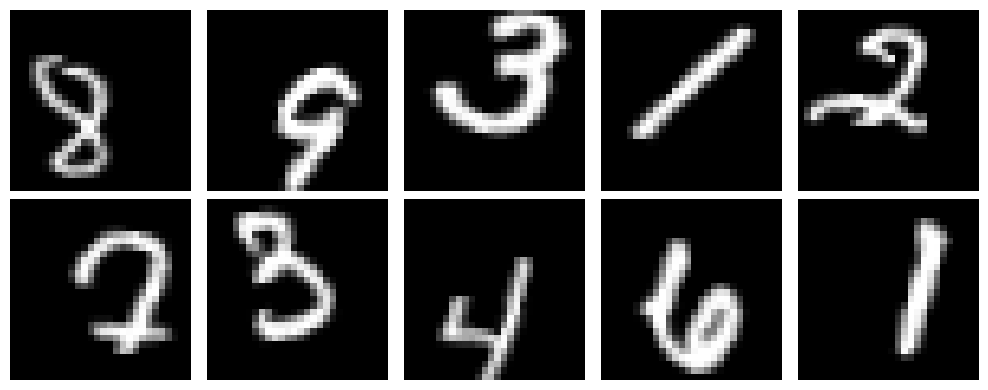

In [22]:
# an iterator can be iterated with a loop as the loop is calling the next() method
print(len(next(train_val_generator))) # tuple of (X_train_val, y_train_val)
print(next(train_val_generator)[0].shape)# 32 samples in a batch of images of
# shape (32,32,3)

plot_samples(next(train_val_generator)[0])


<div style="max-width:66ch;">

## CNN model

</div>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = CNN_model(drop_rate=.5)

model.summary()



c:\Users\utjis\OneDrive - Handelsakademin\AI-Github\AI-Richard-Boden-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,194 (848.41 KB)

 Trainable params: 217,194 (848.41 KB)

 Non-trainable params: 0 (0.00 B)

<div style="max-width:66ch;">

## Train on augmented data

 - steps_per_epoch is the number of times we generate our data from the generator
 - since we have batches on 32 samples for each time we generate, we could count how many samples before we cover original data size
 - 50000/32 = 

</div>

In [24]:
steps_per_epochs = len(X_train_val)/32
validation_steps = len(X_val)/32

steps_per_epochs, validation_steps


(1562.5, 312.5)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=1500,
    epochs=100,
    callbacks=[early_stopper],
    validation_data=val_generator,
    validation_steps=312,
)


Epoch 1/100


c:\Users\utjis\OneDrive - Handelsakademin\AI-Github\AI-Richard-Boden-OPA23\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - acc: 0.6462 - loss: 1.0382 - val_acc: 0.9599 - val_loss: 0.1365
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - acc: 0.9114 - loss: 0.2804 - val_acc: 1.0000 - val_loss: 0.0203
Epoch 3/100
   8/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - acc: 0.8840 - loss: 0.2896  

C:\Users\utjis\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - acc: 0.9141 - loss: 0.2699 - val_acc: 0.9718 - val_loss: 0.0872
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - acc: 0.9351 - loss: 0.1937 - val_acc: 0.9375 - val_loss: 0.0725
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - acc: 0.9347 - loss: 0.2077 - val_acc: 0.9748 - val_loss: 0.0781
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - acc: 0.9424 - loss: 0.1710 - val_acc: 1.0000 - val_loss: 0.0072
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - acc: 0.9446 - loss: 0.1767 - val_acc: 0.9806 - val_loss: 0.0594


In [26]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,acc,loss,val_acc,val_loss
0,0.800559,0.608534,0.959936,0.136498
1,0.911706,0.278650,1.000000,0.020299
2,0.920411,0.251287,0.971755,0.087222
3,0.935516,0.193438,0.937500,0.072518
4,0.937938,0.195445,0.974760,0.078104


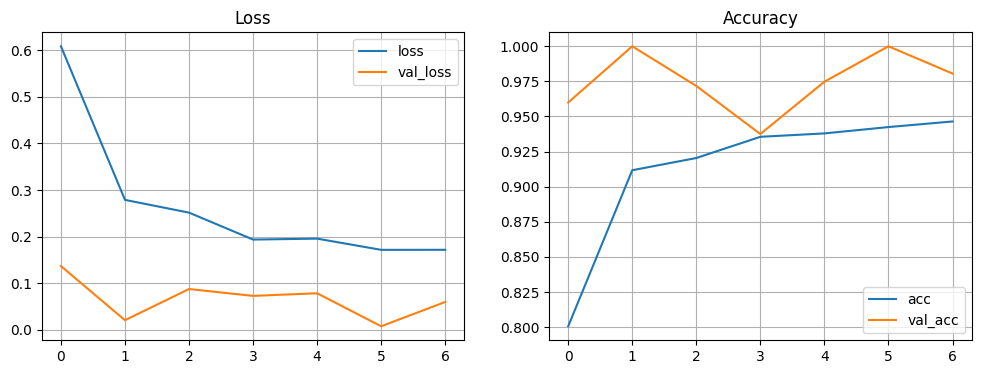

In [29]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

plot_metrics(metrics)
# val accuracy is higher than train accuracy, probably due to train data being
# augmented, which gives a lot of varieties in data and is harder to overfit

## Train on all training data

In [30]:
model = CNN_model()
model.fit(
    train_generator,
    steps_per_epoch=1500,
    epochs=30,
)


Epoch 1/30


c:\Users\utjis\OneDrive - Handelsakademin\AI-Github\AI-Richard-Boden-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


  13/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - acc: 0.1027 - loss: 2.8322  

c:\Users\utjis\OneDrive - Handelsakademin\AI-Github\AI-Richard-Boden-OPA23\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - acc: 0.6279 - loss: 1.1032
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9013 - loss: 0.3149
Epoch 3/30
  15/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - acc: 0.9194 - loss: 0.2818

C:\Users\utjis\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - acc: 0.9122 - loss: 0.2786
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9258 - loss: 0.2315
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - acc: 0.9314 - loss: 0.2184
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9395 - loss: 0.1926
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - acc: 0.9432 - loss: 0.1775
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9494 - loss: 0.1621
Epoch 9/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - acc: 0.9460 - loss: 0.1732
Epoch 10/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9510 - loss: 0.1549
Epoch 11/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - acc: 0.9510 - loss: 0.1557
Epoch 12/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9548 - loss: 0.1419
Epoch 13/30
1249/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9567 - loss: 0.1423

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



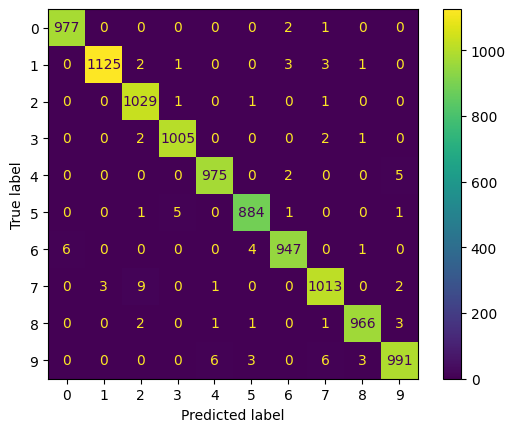

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred)

y_pred = np.argmax(y_pred, axis = 1)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

<div style="max-width:66ch;">

## Summary

In this lecture we've covered data augmentation, which is an important and cheap technique to augment our data to get more variations of data to train the deep learning model. To artificially get even more training data we could use simulation methods to get synthetic datasets. Also generative AI models could be used to get synthetic data for training.
    
</div>

<div style="background-color: #FFF; color: #212121; border-radius: 1px; width:22ch; box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px; display: flex; justify-content: center; align-items: center;">
<div style="padding: 1.5em 0; width: 70%;">
    <h2 style="font-size: 1.2rem;">Kokchun Giang</h2>
    <a href="https://www.linkedin.com/in/kokchungiang/" target="_blank" style="display: flex; align-items: center; gap: .4em; color:#0A66C2;">
        <img src="https://content.linkedin.com/content/dam/me/business/en-us/amp/brand-site/v2/bg/LI-Bug.svg.original.svg" width="20"> 
        LinkedIn profile
    </a>
    <a href="https://github.com/kokchun/Portfolio-Kokchun-Giang" target="_blank" style="display: flex; align-items: center; gap: .4em; margin: 1em 0; color:#0A66C2;">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="20"> 
        Github portfolio
    </a>
    <span>AIgineer AB</span>
<div>
</div>
